In [1]:
# PYTHON IMPORTS and FILE PATHS
import glob
from IPython.display import clear_output
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
matplotlib.rcParams['figure.figsize'] = (26, 26) # Size of the Plots (You might need to run this command twice)
import numpy as np
import cv2 as cv

sequence_path =       '/home/david/KITTI/dataset/sequences/04/' # Which sequence do you want to run?
velo_path =           '/home/david/KITTI/dataset/sequences/04/velodyne/' 
velodyne_files_path = '/home/david/KITTI/dataset/sequences/04/velodyne/*.bin'
cam_two_imgs_path =   '/home/david/KITTI/dataset/sequences/04/image_2/*.png' # Which camera do you want to use?
v2c_filepath =        '/home/david/deepdriving/utils/calib_velo_to_cam.txt'
c2c_filepath =        '/home/david/deepdriving/utils/calib_cam_to_cam.txt'
video_path =          '/home/david/KITTI/projection.mp4' # Video Output

In [2]:
# Lots of functions borrowed from other locations.
# We should identify sources, identify licenses, and give appropriate credit.

def load_velo_from_bin(bin_path):
    obj = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
    # ignore reflectivity info
    return obj[:,:3]

def depth_color(val, min_d=0, max_d=120):
    """
    print Color(HSV's H value) corresponding to distance(m)
    close distance = red , far distance = blue
    """
    np.clip(val, 0, max_d, out=val)  # max distance is 120m but usually not usual
    return (((val - min_d) / (max_d - min_d)) * 120).astype(np.uint8)

def in_h_range_points(points, m, n, fov):
    """ extract horizontal in-range points """
    return np.logical_and(np.arctan2(n, m) > (-fov[1] * np.pi / 180), \
                          np.arctan2(n, m) < (-fov[0] * np.pi / 180))

def in_v_range_points(points, m, n, fov):
    """ extract vertical in-range points """
    return np.logical_and(np.arctan2(n, m) < (fov[1] * np.pi / 180), \
                          np.arctan2(n, m) > (fov[0] * np.pi / 180))

def fov_setting(points, x, y, z, dist, h_fov, v_fov):
    """ filter points based on h,v FOV  """
    if h_fov[1] == 180 and h_fov[0] == -180 and v_fov[1] == 2.0 and v_fov[0] == -24.9:
        return points
    if h_fov[1] == 180 and h_fov[0] == -180:
        return points[in_v_range_points(points, dist, z, v_fov)]
    elif v_fov[1] == 2.0 and v_fov[0] == -24.9:
        return points[in_h_range_points(points, x, y, h_fov)]
    else:
        h_points = in_h_range_points(points, x, y, h_fov)
        v_points = in_v_range_points(points, dist, z, v_fov)
        return points[np.logical_and(h_points, v_points)]

def in_range_points(points, size):
    """ extract in-range points """
    return np.logical_and(points > 0, points < size)

def velo_points_filter(points, v_fov, h_fov):
    """ extract points corresponding to FOV setting """
    # Projecting to 2D
    x = points[:, 0]
    y = points[:, 1]
    z = points[:, 2]
    dist = np.sqrt(x ** 2 + y ** 2 + z ** 2)
    if h_fov[0] < -90:
        h_fov = (-90,) + h_fov[1:]
    if h_fov[1] > 90:
        h_fov = h_fov[:1] + (90,)
    x_lim = fov_setting(x, x, y, z, dist, h_fov, v_fov)[:, None]
    y_lim = fov_setting(y, x, y, z, dist, h_fov, v_fov)[:, None]
    z_lim = fov_setting(z, x, y, z, dist, h_fov, v_fov)[:, None]
    # Stack arrays in sequence horizontally
    xyz_ = np.hstack((x_lim, y_lim, z_lim))
    xyz_ = xyz_.T
    # stack (1,n) arrays filled with the number 1
    one_mat = np.full((1, xyz_.shape[1]), 1)
    xyz_ = np.concatenate((xyz_, one_mat), axis=0)
    # need dist info for points color
    dist_lim = fov_setting(dist, x, y, z, dist, h_fov, v_fov)
    color = depth_color(dist_lim, 0, 70)
    return xyz_, color

def calib_velo2cam(filepath):
    """
    get Rotation(R : 3x3), Translation(T : 3x1) matrix info
    using R,T matrix, we can convert velodyne coordinates to camera coordinates
    """
    with open(filepath, "r") as f:
        file = f.readlines()
        for line in file:
            (key, val) = line.split(':', 1)
            if key == 'R':
                R = np.fromstring(val, sep=' ')
                R = R.reshape(3, 3)
            if key == 'T':
                T = np.fromstring(val, sep=' ')
                T = T.reshape(3, 1)
    return R, T

def calib_cam2cam(filepath, mode):
    """
    If your image is 'rectified image' :
        get only Projection(P : 3x4) matrix is enough
    but if your image is 'distorted image'(not rectified image) :
        you need undistortion step using distortion coefficients(5 : D)
    in this code, I'll get P matrix since I'm using rectified image
    """
    with open(filepath, "r") as f:
        file = f.readlines()

        for line in file:
            (key, val) = line.split(':', 1)
            if key == ('P_rect_0' + mode):
                P_ = np.fromstring(val, sep=' ')
                P_ = P_.reshape(3, 4)
                # erase 4th column ([0,0,0])
                P_ = P_[:3, :3]
    return P_

def velo2cam(points, v_fov, h_fov, vc_path, cc_path, mode='02'):
    """ print velodyne 3D points corresponding to camera 2D image """
    # R_vc = Rotation matrix ( velodyne -> camera )
    # T_vc = Translation matrix ( velodyne -> camera )
    R_vc, T_vc = calib_velo2cam(vc_path)
    # P_ = Projection matrix ( camera coordinates 3d points -> image plane 2d points )
    P_ = calib_cam2cam(cc_path, mode)
    """
    xyz_v - 3D velodyne points corresponding to h, v FOV in the velodyne coordinates
    color    - color value(HSV's Hue) corresponding to distance(m)
             [x_1 , x_2 , .. ]
    xyz_v =  [y_1 , y_2 , .. ]   
             [z_1 , z_2 , .. ]
             [ 1  ,  1  , .. ]
    """
    xyz_v, color = velo_points_filter(points, v_fov, h_fov)

    """
    RT_ - rotation matrix & translation matrix
        ( velodyne coordinates -> camera coordinates )

            [r_11 , r_12 , r_13 , t_x ]
    RT_  =  [r_21 , r_22 , r_23 , t_y ]   
            [r_31 , r_32 , r_33 , t_z ]
    """
    RT_ = np.concatenate((R_vc, T_vc), axis=1)
    # convert velodyne coordinates(X_v, Y_v, Z_v) to camera coordinates(X_c, Y_c, Z_c)
    for i in range(xyz_v.shape[1]):
        xyz_v[:3, i] = np.matmul(RT_, xyz_v[:, i])
    """
    xyz_c - 3D velodyne points corresponding to h, v FOV in the camera coordinates
             [x_1 , x_2 , .. ]
    xyz_c =  [y_1 , y_2 , .. ]   
             [z_1 , z_2 , .. ]
    """
    xyz_c = np.delete(xyz_v, 3, axis=0)

    # convert camera coordinates(X_c, Y_c, Z_c) image(pixel) coordinates(x,y)
    for i in range(xyz_c.shape[1]):
        xyz_c[:, i] = np.matmul(P_, xyz_c[:, i])
    """
    xy_i - 3D velodyne points corresponding to h, v FOV in the image(pixel) coordinates before scale adjustment
    ans  - 3D velodyne points corresponding to h, v FOV in the image(pixel) coordinates
             [s_1*x_1 , s_2*x_2 , .. ]
    xy_i =   [s_1*y_1 , s_2*y_2 , .. ]        ans =   [x_1 , x_2 , .. ]  
             [  s_1   ,   s_2   , .. ]                [y_1 , y_2 , .. ]
    """
    xy_i = xyz_c[::] / xyz_c[::][2]
    points = np.delete(xy_i, 2, axis=0)
    """
    width = 1242
    height = 375
    w_range = in_range_points(ans[0], width)
    h_range = in_range_points(ans[1], height)
    ans_x = ans[0][np.logical_and(w_range,h_range)][:,None].T
    ans_y = ans[1][np.logical_and(w_range,h_range)][:,None].T
    color = color[np.logical_and(w_range,h_range)]
    ans = np.vstack((ans_x, ans_y))
    """
    return points, color

def print_projection_cv(points, color, image):
    """ project converted velodyne points into camera image """
    hsv_image = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    for i in range(points.shape[1]):
        cv.circle(hsv_image, (np.int32(points[0][i]), np.int32(points[1][i])), 2, (int(color[i]), 255, 255), -1)
    return cv.cvtColor(hsv_image, cv.COLOR_HSV2BGR)

def print_projection_plt(points, color, image):
    """ project converted velodyne points into camera image """
    hsv_image = cv.cvtColor(image, cv.COLOR_RGB2HSV)
    for i in range(points.shape[1]):
        cv.circle(hsv_image, (np.int32(points[0][i]), np.int32(points[1][i])), 2, (int(color[i]), 255, 255), -1)
    return cv.cvtColor(hsv_image, cv.COLOR_HSV2RGB)

(124231, 3)
(370, 1226, 3)


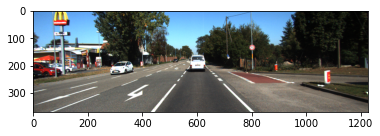

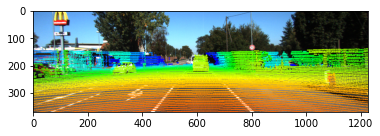

In [3]:
# bin file -> numpy array
velo_points = load_velo_from_bin(velo_path+'000000.bin')
print(velo_points.shape)

#read left camera image
image_type = 'color'  # 'grayscale' or 'color' image
mode = '0' if image_type == 'grayscale' else '2'  # image_00 = 'grayscale image' , image_02 = 'color image'

image = Image.open(sequence_path+'image_'+mode+'/000000.png')
image = np.array(image)
print(image.shape)

plt.figure()
plt.imshow(image)

points, color = velo2cam(velo_points, v_fov=(-24.9, 2.0), h_fov=(-45, 45), vc_path=v2c_filepath, cc_path=c2c_filepath, mode=mode)
image = print_projection_plt(points=points, color=color, image=image)
image = np.array(image)

# display result image
plt.figure()
plt.imshow(image)
height = image.shape[0]
width = image.shape[1]

In [4]:
""" save result video """
lidar_points = sorted(glob.glob(velodyne_files_path))
image = sorted(glob.glob(cam_two_imgs_path))

fourcc = cv.VideoWriter_fourcc(*'XVID')
vid = cv.VideoWriter(video_path, fourcc, 25.0, (width, height))

for i, point in enumerate(lidar_points):
    print(round(i/len(lidar_points)*100,1),'%')
    velo = load_velo_from_bin(point)
    img = cv.imread(str(image[i]))
    ans, c_ = velo2cam(velo, v_fov=(-24.9, 2.0), h_fov=(-50, 50), vc_path=v2c_filepath, cc_path=c2c_filepath, mode=mode)
    img = print_projection_cv(points=ans, color=c_, image=img)
    vid.write(img)

vid.release()

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


0.0 %
0.4 %
0.7 %
1.1 %
1.5 %
1.8 %
2.2 %
2.6 %
3.0 %
3.3 %
3.7 %
4.1 %
4.4 %
4.8 %
5.2 %
5.5 %
5.9 %
6.3 %
6.6 %
7.0 %
7.4 %
7.7 %
8.1 %
8.5 %
8.9 %
9.2 %
9.6 %
10.0 %
10.3 %
10.7 %
11.1 %
11.4 %
11.8 %
12.2 %
12.5 %
12.9 %
13.3 %
13.7 %
14.0 %
14.4 %
14.8 %
15.1 %
15.5 %
15.9 %
16.2 %
16.6 %
17.0 %
17.3 %
17.7 %
18.1 %
18.5 %
18.8 %
19.2 %
19.6 %
19.9 %
20.3 %
20.7 %
21.0 %
21.4 %
21.8 %
22.1 %
22.5 %
22.9 %
23.2 %
23.6 %
24.0 %
24.4 %
24.7 %
25.1 %
25.5 %
25.8 %
26.2 %
26.6 %
26.9 %
27.3 %
27.7 %
28.0 %
28.4 %
28.8 %
29.2 %
29.5 %
29.9 %
30.3 %
30.6 %
31.0 %
31.4 %
31.7 %
32.1 %
32.5 %
32.8 %
33.2 %
33.6 %
33.9 %
34.3 %
34.7 %
35.1 %
35.4 %
35.8 %
36.2 %
36.5 %
36.9 %
37.3 %
37.6 %
38.0 %
38.4 %
38.7 %
39.1 %
39.5 %
39.9 %
40.2 %
40.6 %
41.0 %
41.3 %
41.7 %
42.1 %
42.4 %
42.8 %
43.2 %
43.5 %
43.9 %
44.3 %
44.6 %
45.0 %
45.4 %
45.8 %
46.1 %
46.5 %
46.9 %
47.2 %
47.6 %
48.0 %
48.3 %
48.7 %
49.1 %
49.4 %
49.8 %
50.2 %
50.6 %
50.9 %
51.3 %
51.7 %
52.0 %
52.4 %
52.8 %
53.1 %
53.5 %
53.9 

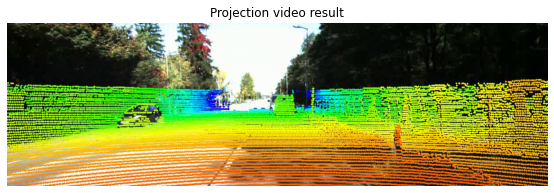

In [5]:
""" display video """
vid = cv.VideoCapture(video_path)

while (True):
    ret, frame = vid.read()
    if not ret:
        vid.release()
        break
    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(12, 3))
    plt.title("Projection video result")
    plt.axis('off')
    plt.imshow(frame)
    plt.show()
    plt.pause(0.1)
    # clear current frame for next frame
    clear_output(wait=True)

vid.release()